# OVERVIEW:

World wide the anime industry is valued at USD 34.06 billion dollars, and is expected to grow to over USD 110.82 dollars by the end of 2037. Among the fandom there has always been a debate on how well the industry understands the interest of its fandom. This project will utilize data from anilist.co to measure trends in the anime industry as it relates to genres, original sources, and other meta data indicators (e.g. tags). We will look at the frequency of these markers as well as aggregate user data representing the popularity of each of the markers.

## Scope of Project:

We will limit ourselves to more modern trends focusing on the twenty year period of 2005 until the end of 2024.

- What **genres** are have had the most representation within the industry? 
	- Included genres are Action, Adventure, Comedy, Drama, Ecchi, Fantasy, Horror, Mahou Shoujo, Mecha, Music, Mystery, Psychological, Romance, Sci-Fi, Slice of Life, Sports, Supernatural, and Thriller.
- What **original sources** have had the most representation within the industry?
	- Sources include Manga, Light Novels, Visual Novels, Video Games, Originals, and others.
- As well as some **media tags** that have affected the industry in the minds of fans and cooperate trends alike.
	- Media tags included are School Clubs, Otaku Culture, Love Triangle, Coming of Age, Cute Girls Doing Cute Things, Isekai, Reincarnation, Iyashikei, and Primarily Adult Cast.

## Known Limitations:

 - For our pourposes "popularity" will refer to the number of times a member of anilist has added a show to a list.
	 - This means any designation including curently watching, completed, planed to watch, and dropped.
	 - This was chosen over a subjective metric like average rating because the number of eyes on a show better reflects the effectivness of	a genre, source, or tag to draw attention, be it positive or negative.
 - Anilist is primarily a western english speaking platform, we can assume that this will be reflected in the accumulated popularity metrics.
 - Anilist includes hundreds of tags in its library. I have chose a select few based on common observances in community conversation. Ignored	where tags that were better represented in genres as well tags referring to demographics such as Shonen, Shojo, etc. There where also tags that were decidedly not represented enough to be included in this analysis.

In [1]:
import pandas as pd
import requests
import json
import sqlite3
import numpy as np
import time
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import re as re
import seaborn as sns
from ast import literal_eval

# Introduction of our Data:

We will be utilizing data that was compiled from https://anilist.co using their graphQL API. You can find the functions to call the list in complie_list.ipynb.
Here we will use the pre-compiled list from complete_anilist.csv. This data was compiled in early 2025, and only includes shows that were marked as the finished status.

## Import Data:

In [4]:
df = pd.read_csv("complete_anilist.csv")
df

,id,type,format,status,seasonYear,source,genres,popularity,tags,title.english,title.romaji
0,1,ANIME,TV,FINISHED,1998.0,ORIGINAL,"['Action', 'Adventure', 'Drama', 'Sci-Fi']",380694,"[{'name': 'Space'}, {'name': 'Crime'}, {'name'...",Cowboy Bebop,Cowboy Bebop
1,5,ANIME,MOVIE,FINISHED,2001.0,ORIGINAL,"['Action', 'Drama', 'Mystery', 'Sci-Fi']",70431,"[{'name': 'Terrorism'}, {'name': 'Primarily Ad...",Cowboy Bebop: The Movie - Knockin' on Heaven's...,Cowboy Bebop: Tengoku no Tobira
2,6,ANIME,TV,FINISHED,1998.0,MANGA,"['Action', 'Adventure', 'Comedy', 'Drama', 'Sc...",136780,"[{'name': 'Guns'}, {'name': 'Fugitive'}, {'nam...",Trigun,TRIGUN
3,7,ANIME,TV,FINISHED,2002.0,ORIGINAL,"['Action', 'Drama', 'Mystery', 'Supernatural']",18663,"[{'name': 'Conspiracy'}, {'name': 'Police'}, {...",Witch Hunter ROBIN,Witch Hunter ROBIN
4,8,ANIME,TV,FINISHED,2004.0,MANGA,"['Adventure', 'Fantasy', 'Supernatural']",2614,"[{'name': 'Shounen'}, {'name': 'Spearplay'}, {...",Beet the Vandel Buster,Bouken Ou Beet
...,...,...,...,...,...,...,...,...,...,...,...
18386,186761,ANIME,MOVIE,FINISHED,NaN,OTHER,"['Comedy', 'Drama']",3,[],NaN,Ban Ye Ji Jiao
18387,186762,ANIME,MOVIE,FINISHED,NaN,OTHER,['Comedy'],4,[],NaN,Cao Chong Cheng Xiang
18388,186763,ANIME,MOVIE,FINISHED,NaN,OTHER,"['Drama', 'Fantasy']",4,[{'name': 'Dragons'}],NaN,Diao Long Ji
18389,186764,ANIME,MOVIE,FINISHED,2024.0,NaN,['Fantasy'],138,"[{'name': 'Virtual World'}, {'name': 'Female P...",NaN,SINoALICE: Ichiban Saigo no Monogatari


# Cleaning Data:

In [3]:
def clean_list(df: pd.DataFrame) -> pd.DataFrame:
    df = df[(df.format != "MOVIE") & (df.format != "SPECIAL") & (df.format != "MUSIC") & (df.format != "TV_SHORT") & (df.format.notnull())] #remove unnecesary formats
    df['title.english'] = df['title.english'].fillna(df['title.romaji'])  #clean english title
    df_2 = df.dropna(subset=['seasonYear']) #Drop entries with no listed year.
    df_2 = df_2.drop(['title.romaji','status','type'],axis=1) #drop romaji title
    df_2['source'] = df_2['source'].fillna('OTHER') #replace unknown source with "OTHER"
    df_2['seasonYear'] = df_2['seasonYear'].astype(int)
    df_2.rename(columns={'title.english' : 'Title'}, inplace=True)    
    df_2.rename(columns={'seasonYear' : 'Year'}, inplace=True)
    df_2.columns = df_2.columns.str.capitalize()
    df_3 = df_2[(df_2['Year'] > 2004) & (df_2['Year'] <= 2024)] #Reduce scope to years between 2005 and 2025
    return df_3

In [5]:
anilist = clean_list(df)

C:\Users\Leolion023\AppData\Local\Temp\ipykernel_128124\1094374626.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['title.english'] = df['title.english'].fillna(df['title.romaji'])  #clean english title


In [6]:
anilist

,Id,Format,Year,Source,Genres,Popularity,Tags,Title
5,15,TV,2005,MANGA,"['Action', 'Comedy', 'Sports']",29079,"[{'name': 'American Football'}, {'name': 'Shou...",Eyeshield 21
6,16,TV,2005,MANGA,"['Comedy', 'Drama', 'Romance', 'Slice of Life']",50455,"[{'name': 'Coming of Age'}, {'name': 'Josei'},...",Honey and Clover
16,27,TV,2005,LIGHT_NOVEL,"['Action', 'Drama', 'Horror', 'Sci-Fi', 'Super...",23424,"[{'name': 'Vampire'}, {'name': 'Male Protagoni...",Trinity Blood
30,50,TV,2005,MANGA,"['Comedy', 'Romance', 'Supernatural']",21661,"[{'name': 'Magic'}, {'name': 'Primarily Female...",Oh! My Goddess (TV)
45,65,TV,2005,MANGA,"['Action', 'Comedy', 'Drama']",14749,"[{'name': 'Battle Royale'}, {'name': 'Magic'},...",Rozen Maiden: Dreaming
...,...,...,...,...,...,...,...,...
18283,185463,ONA,2023,ORIGINAL,"['Drama', 'Psychological']",361,[],Artiswitch: Ruru's Episodes of Memories
18287,185541,ONA,2024,ORIGINAL,['Adventure'],124,[],Future Folktales Season 2
18293,185642,ONA,2023,ORIGINAL,"['Horror', 'Supernatural']",90,[],Nanashi Kaidan 2nd Season
18294,185644,TV,2024,OTHER,"['Comedy', 'Fantasy', 'Mystery']",22,[],Oshiri Tantei 8


# Eploring the Data:

## Source data over the years:

Where does anime come from? All media has an origin, anime is no exception. The conventional wisdom is that the vast majority of anime have thier origin manga. However, over the past several years there has been a large uptick in shows that come from light novels. Has ligh novel based anime taken over manga as the top source material?

Where does the best anime come from? Often it is touted that the best anime are original contet with no previous work to base artistic intent. Yet, is this true, should companies be putting more effort into original content or is it better to keep pushing out as much manga and light novel content? 

The folowing section explores the data on these questions over the last twenty years.

In [7]:
anilist.groupby('Source').Title.count()

Source
LIGHT_NOVEL      672
MANGA           1888
ORIGINAL        1127
OTHER            651
VIDEO_GAME       388
VISUAL_NOVEL     190
Name: Title, dtype: int64

Unsurprisingly, manga has been king when it comes to number of conversions to anime. What is more interesting, is that original content has outpaced light novels over the last twenty years. Let's look at how the numbers have changed year by year.

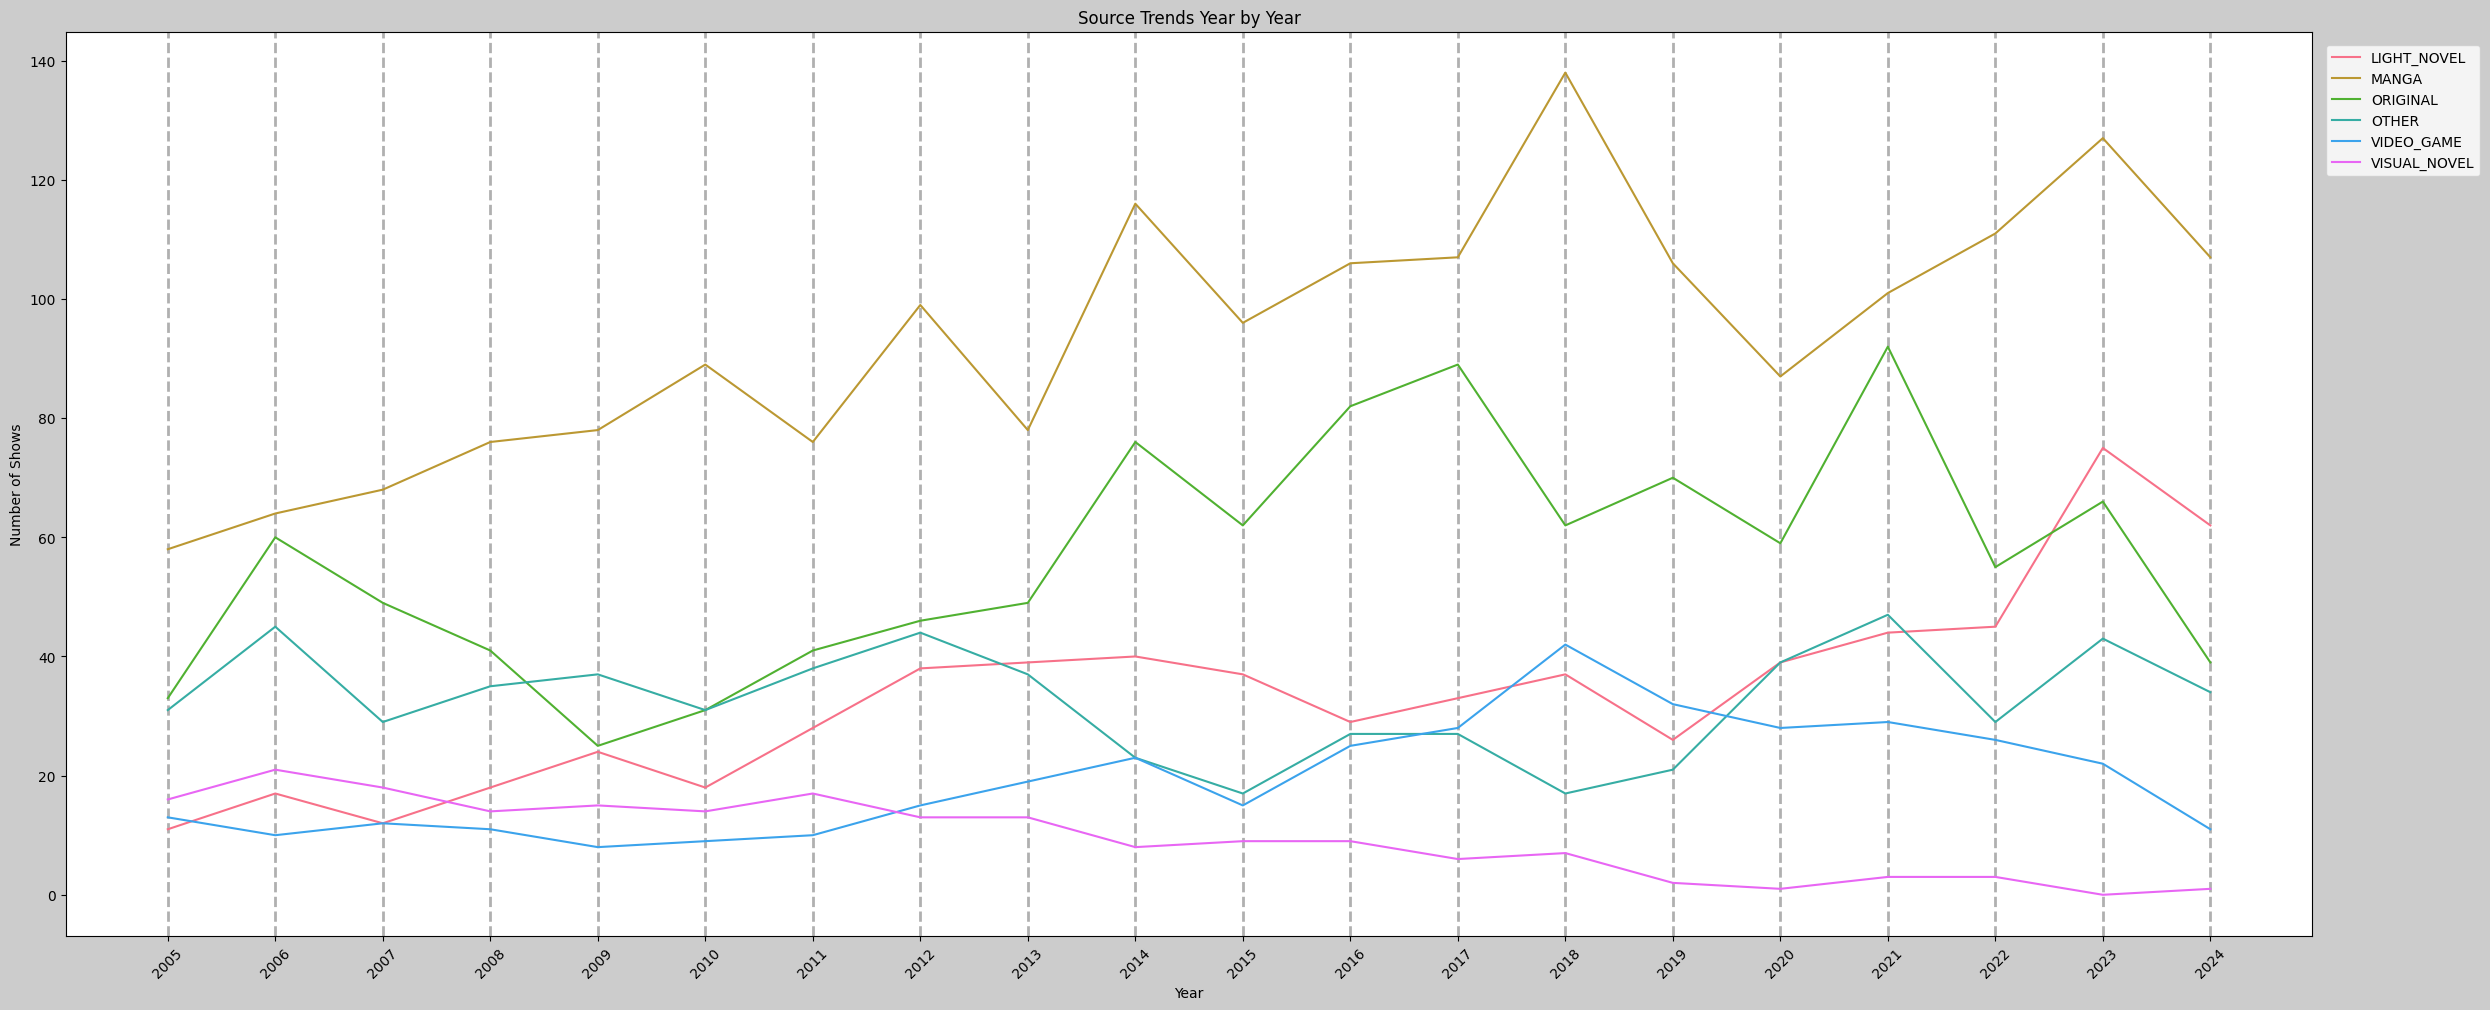

In [8]:
# Pivot the data to have source as columns and years as index
source_trends = anilist.pivot_table(values='Title', index='Year', columns='Source', aggfunc='count', fill_value=0)
colors = sns.color_palette('husl', 6)
# Plotting
plt.figure(figsize=(25, 10),facecolor='#cccccc')

# Here we create line plots for each source
for i,tag in enumerate(source_trends.columns):
    plt.plot(source_trends.index, source_trends[tag], label=tag, color=colors[i % len(colors)])

plt.title('Source Trends Year by Year')
plt.xlabel('Year')
plt.ylabel('Number of Shows')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=1.)
plt.grid(True, which='both', axis='x', linestyle='--', linewidth=2)

# Adjust layout to prevent clipping of the legend
plt.tight_layout()

plt.xticks(range(min(source_trends.index), max(source_trends.index) + 1))
plt.xticks(rotation=45)

# Show the plot
plt.show()

### Trend results:
While manga has maintained its overwelming hold on anime sources, the growth of light novels has not been as fast or overwelming as the community has felt. Infact up until 2023 original content has widely been number second place. Then why is it that there is often a lament that all the best anime are original content and yet companies continue to push boring light novel content? Lets look and see if original content really lives up to its expectations.

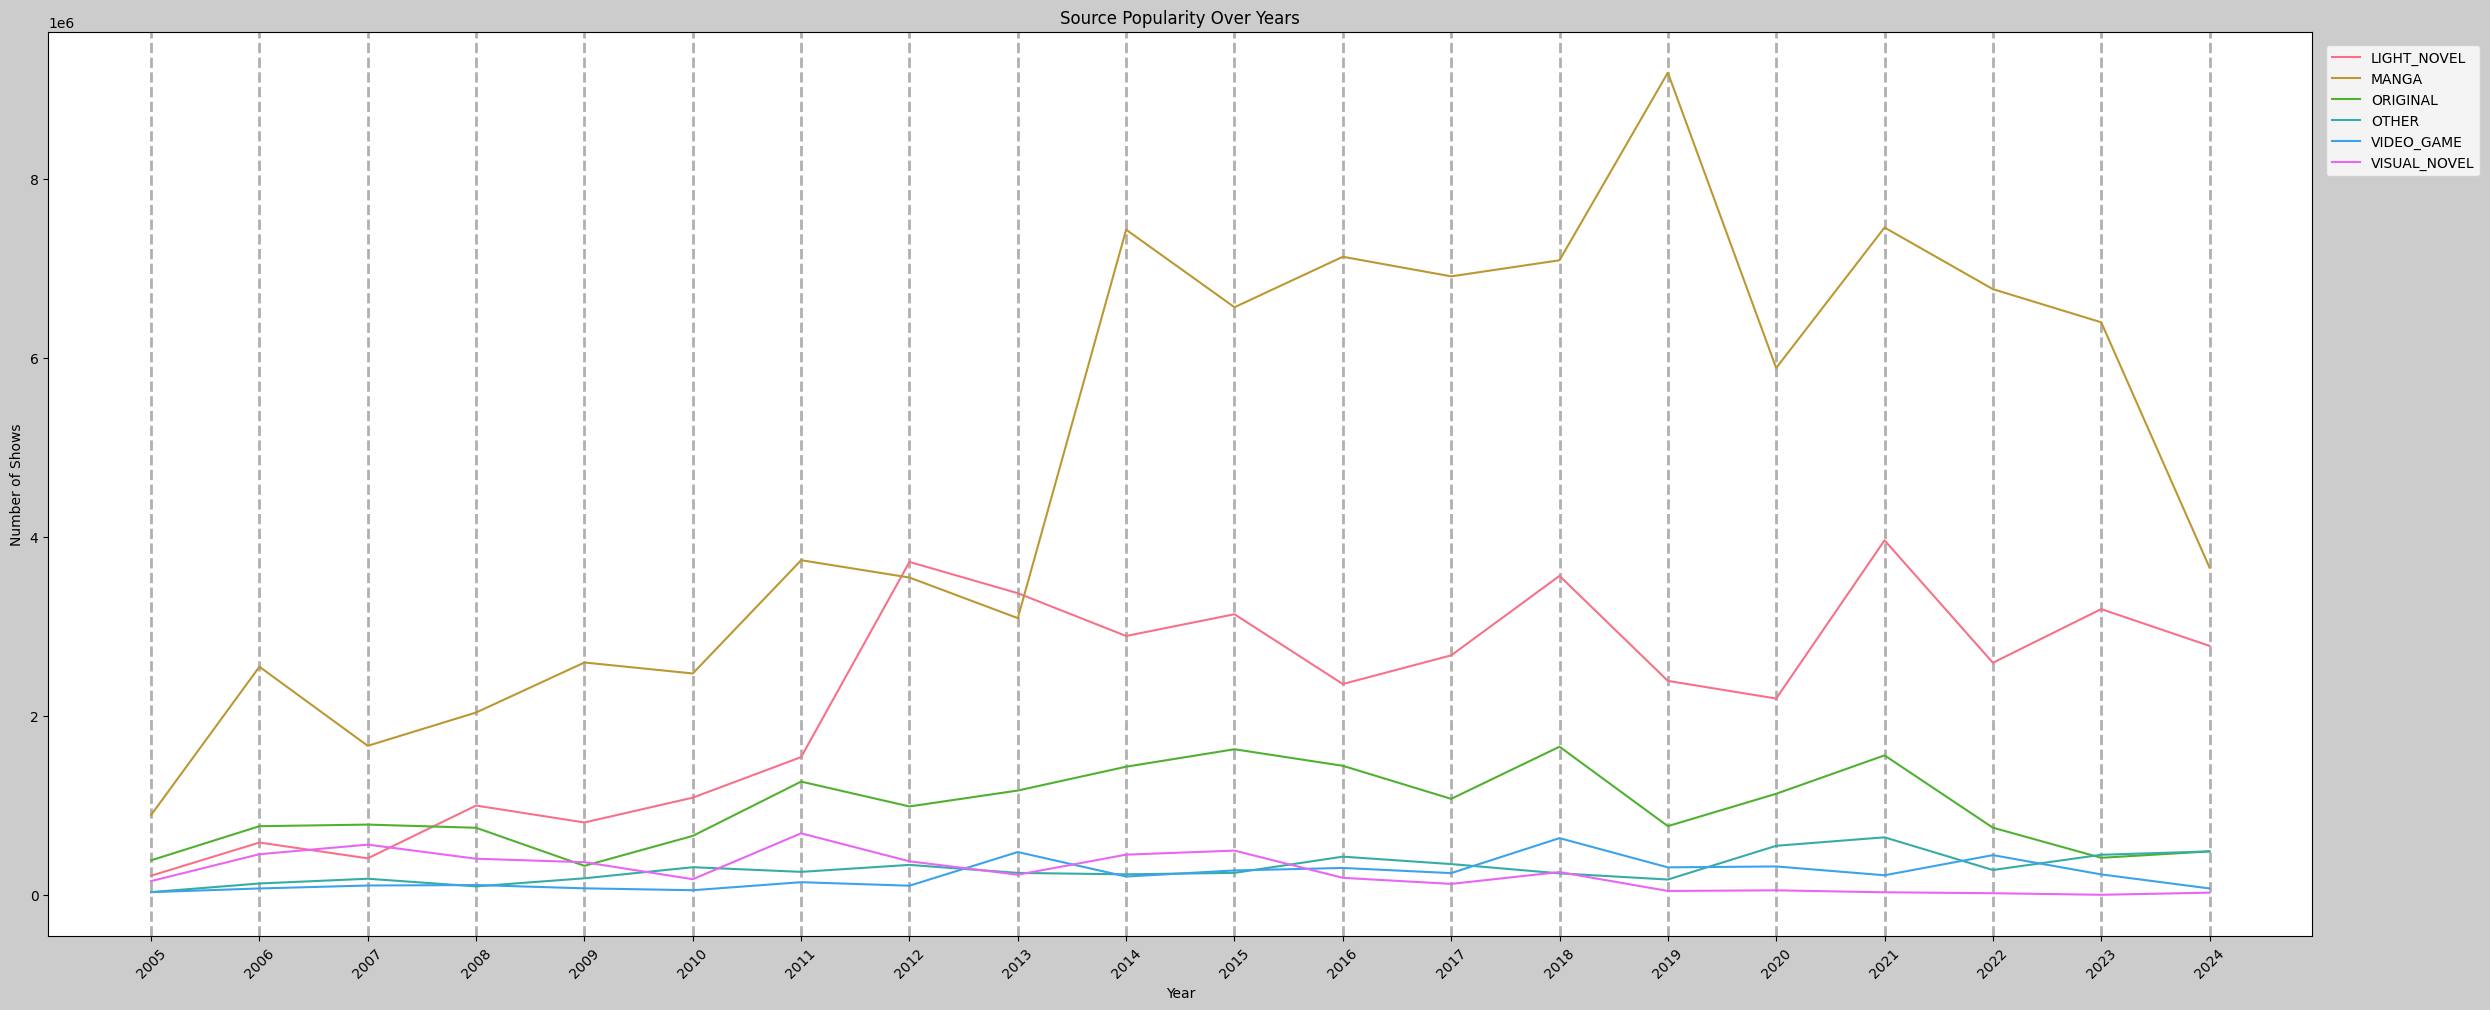

In [10]:
# Pivot the data to have source as columns and years as index
source_popularity = anilist.pivot_table(values='Popularity', index='Year', columns='Source', aggfunc='sum', fill_value=0)
colors = sns.color_palette('husl', 6)
# Plotting
plt.figure(figsize=(25, 10),facecolor='#cccccc')

# Here we create line plots for each source
for i,tag in enumerate(source_popularity.columns):
    plt.plot(source_popularity.index, source_popularity[tag], label=tag, color=colors[i % len(colors)])

plt.title('Source Popularity Over Years')
plt.xlabel('Year')
plt.ylabel('Number of Shows')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=1.)
plt.grid(True, which='both', axis='x', linestyle='--', linewidth=2)

# Adjust layout to prevent clipping of the legend
plt.tight_layout()

plt.xticks(range(min(source_popularity.index), max(source_popularity.index) + 1))
plt.xticks(rotation=45)

# Show the plot
plt.show()

### Popularity Results:

It turns out that despite original content being touted as the surperior source, light novel anime have had more eyes on them since 2008. That is despite fighting video game content and other sources for third place in the year by year show count. In fact, over the last four years original content is recieving less eyes than ever. It wans't until 2023 that light novels took over original contet for the second spot. In the future this trend will likely continue as the industry seeks to take fewer high risk, high reward chances on original content.


## Genre Trends Year by Year: